In [1]:
# CSS formatting for the Notebook. Run to apply format
from IPython.core.display import HTML;      
HTML("""<link rel="stylesheet" href="./custom.css">""")

<div id=headerNotebook>
<h1 class=headtitle><b>Anomaly Detection in Network Traffic with K-means clustering</b><br/>2017 Edition</h1>
<div class=date>10/05/2017</div>
<div class=authors><b>Authors</b>     Ole Andreas Hansen |
                            Alberto Ibarrondo Luis</div>
                            </div>

# Anomaly Detection in Network Traffic with K-means clustering

We can categorize machine learning algorithms into two main groups: **supervised learning** and **unsupervised learning**. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called **clusters**. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well-known clustering algorithm to detect anomaly network connections based on statistics about each of them. A thorough overview of K-means clustering, from a research perspective, can be found in the following wonderful [tutorial](http://theory.stanford.edu/~sergei/slides/kdd10-thclust.pdf).

## Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

## Steps

1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unusual connections.

# 1. K-means
## 1.1. Introduction
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of $k$, it tries to build $k$ clusters from samples in the dataset. Therefore, $k$ is an hyperparameter of the model. The right value of $k$ is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measure the similarity between any two data points, K-means requires the definition of a distance function between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a $d$-dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a $d$-dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

## 1.2. How does it work?
Given $k$, the K-means algorithm works as follows:

1. Randomly choose $k$ data points (seeds) to be the initial centroids
2. Assign each data point to the **closest centroid**
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result.
From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centers of those runs and input the centers as initial ones for one final run of the analysis.

## 1.3. Illustrative example
One of the best ways to study an algorithm is trying implement it.
In this section, we will go step by step to implement a simple K-means algorithm.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 1

#### Question 1.1
<div class="alert alert-info">

Complete the below function to calculate an Euclidean distance between any two points in $d$-dimensional data space

</div>

In [20]:

import numpy as np

# calculate distance between two d-dimensional points
def e_dist(p1, p2):
    return np.linalg.norm(np.array(p1)-np.array(p2))

# test our function
#assert (round(e_dist([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"
#assert (round(e_dist([1,1,0] , [0,0,-2]), 2) == 2.45), "Function's wrong"

#### Question 1.2
<div class="alert alert-info">

Given a data point and the current set of centroids, complete the function below to find the index of the closest centroid for that data point.

</div>

In [19]:
def cl_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    distances = list(map(lambda centroid: e_dist(datapoint, centroid), centroids))
    return np.argmin(distances)

assert(cl_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"

#### Question 1.3
<div class="alert alert-info">

Write a function to randomize `k` initial centroids.

</div>

In [21]:


# randomize initial centroids
def randomize_centroids(data, k):
    centroids_idx = np.random.permutation(range(len(data)))
    #Better this than shuffle? shuffle does it inline
    return [data[c] for c in centroids_idx[:k]]

#Any other ways of randomizinf the centroids?
dataExample = np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ])
assert(len(randomize_centroids(dataExample, 2)) == 2), "Wrong function"
randomize_centroids(dataExample, 2)


[array([2, 1, 2]), array([3, 1, 2])]

<div class="alert alert-warning">
<b>COMMENT:</b><br/>
Choosing the centroid: Select random points from the dataset. A better way to do it, and the one we picked, is to assign centroids using some extra information from the rest of the cluster (reducing the bias in our initial decission). This can be achieved for example by averaging between several sets of points extracted from the dataset. Other options are:
<ul>
<li>Randomly set the features from the centroids using as interval the max-min values in the dataset (a hypercube). This one doesn't assure you a good initial set Even if you tried to model the distribution on each feature, there would be no notion of correlation between features, not would it be a measurement of the initial distance between centroids.</li>
<li>Set the first centroid from a datapoint, then set the next one to another data point with probability p depending on the distance (the bigger the distance, the more probable it is). This is the algorithm of KMeans++. Very good but computationally intensive.</li>
</ul>
<br/>
Also, we should use permutation in the indexes of the data insted of permuting the data itself (or shuffling it), thus making it more efficient.
</div>

#### Question 1.4
<div class="alert alert-info">

Write function `check_converge` to check the stop criteria of the algorithm.

</div>

In [22]:
MAX_ITERATIONS = 1000

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if (num_iterations>MAX_ITERATIONS): return True
    # check if the centroids don't move (or very slightly)
    return (np.sum(list(map(lambda c: e_dist(c[0], c[1]), zip(centroids, old_centroids))))<=threshold)

<div class="alert alert-warning">
<b>COMMENT:</b><br/>
The stopping criteria we've chosen is based on distorsion: the total distance covered by the centroids in their lat movement to be smaller than a threshold. The threshold could be applied instead to each centroid, but we found more useful to have a measurement of the centroids' movement as a metric of the convergence. 
</div>

#### Question 1.5
<div class="alert alert-info">

Write function `update_centroid` to update the new positions for the current centroids based on the position of their members.

</div>

In [23]:
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, cluster):
    new_centroids = list(map(lambda cl : np.average(cl, axis=0), np.array(cluster)))
    return new_centroids

#### Question 1.6
<div class="alert alert-info">

Complete the K-means algorithm skeleton below, with the functions you wrote above.

</div>

In [7]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None, threshold=0):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1
        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for x in data:
            # find the closest center of each data point
            centroid_idx = cl_centroid(x, centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(x)
        
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        
        # update centroids
        centroids = update_centroids(centroids, clusters)
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations, threshold):
            break
    
    return centroids


Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

#### Question 1.7
<div class="alert alert-info">

The code below can be used to test your algorithm with three different datasets: `Iris`, `Moon` and `Blob`.
Run your algorithm to cluster datapoints in these datasets, plot the results and discuss about them. Do you think that our algorithm works well? Why?

</div>

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:
/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


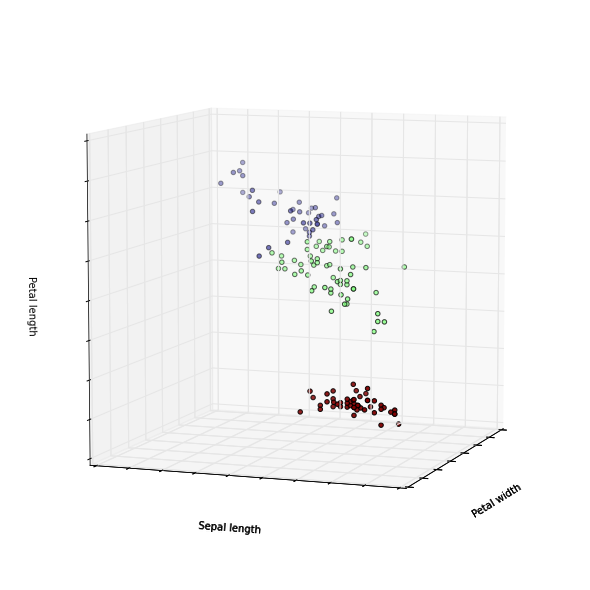

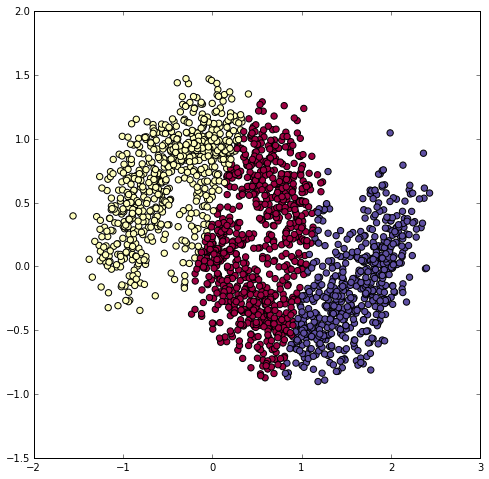

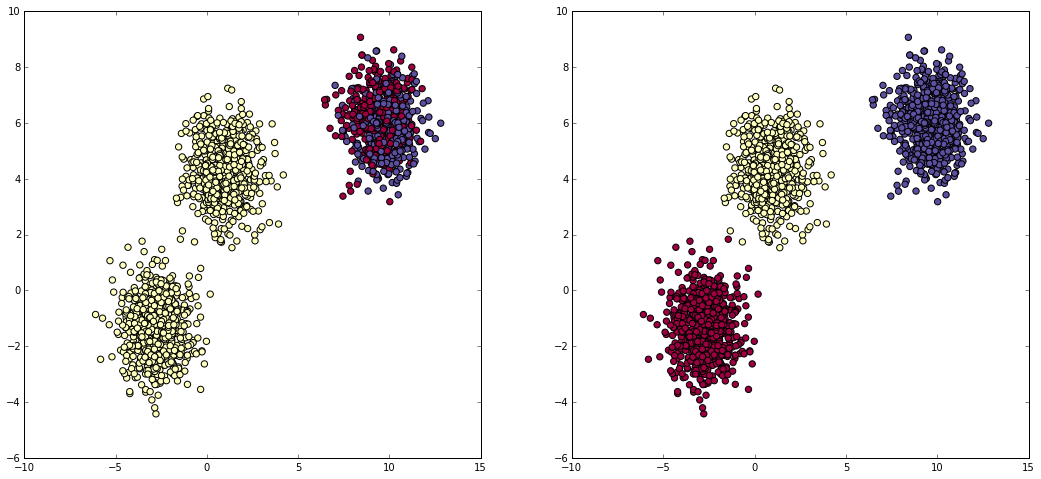

In [10]:
%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

_
# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers = kmeans(X_iris, k=3)
labels = [cl_centroid(p, centers) for p in X_iris]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
plt.show()

# moon
plt.figure(figsize=(8,8))
X, y = datasets.make_moons(2000, noise=0.2)
centers = kmeans(X, k=3)
labels = [cl_centroid(p, centers) for p in X]
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)
plt.show()

# blob
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
np.random.seed(0)
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)
centers = kmeans(X, k=3)
labels = [cl_centroid(p, centers) for p in X]
fig = plt.figure(1, figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)


plt.subplot(1,2,2)
np.random.seed(3)
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)
centers = kmeans(X, k=3)
labels = [cl_centroid(p, centers) for p in X]
fig = plt.figure(1, figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

plt.show()

<div class="alert alert-warning">

<b>COMMENT:</b><br/>
As we can see, our implementation works well in some cases (last example, second example), but it lacks a proper approach as shown in the third example.<br/><br/>
In the First plot we obtain what initially seems to be a very good clustering since it separates into evenly distributed groups.<br/><br/>

After experimenting with different initializations, what we can definitely conclude is that results vary significantly depending on the initial centroids. We'll keep that in mind for the rest of the notebook.

</div>

That's enough about K-means for now. In the next section, we will apply MMLIB's K-means on Spark to deal with a large data in the real usecase.


# 2. Usecase: Network Intrusion 

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.


## 2.1. Data
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each feature, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## 2.2. Clustering without using categorical features

First, we need to import some packages that are used in this notebook.

In [6]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)


from matplotlib.colors import ListedColormap

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#4daf4a', '#377eb8', '#e41a1c' ])
dark2_cmap=ListedColormap(dark2_colors)

### 2.2.1. Loading data

There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1**: we don't use the labels in the training phase!!!

**Note 2**: in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Write function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

</div>

Where,

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

In [3]:
def parseLine(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    vector = np.delete(vector, [1, 2, 3]) #[vector[0]+vector[4:]]
    
    # convert each value from string to float
    vector = np.array(vector).astype(float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.map(lambda x: x[1]).cache()


# number of connections
n = data.count()

In [4]:
print('Size of data: ',n)
print('Class of the data object:',type(data))

Size of data:  4898431
Class of the data object: <class 'pyspark.rdd.PipelinedRDD'>


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 3
<div class="alert alert-info">

Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

</div>  

You can use the following parameters:  

<ul>

  <li>`maxIterations=10`</li>
  <li>`runs=10`</li>
  <li>`initializationMode="random"`</li>

</ul>  

Discuss the result from your figure.

In [14]:
clusters = KMeans.train(data, k=2, maxIterations=10, runs=10, initializationMode="random")

In [5]:
clusters_kpp = KMeans.train(data, k=2, maxIterations=10, initializationMode='k-means||')

<div class="alert alert-warning">

<b>COMMENT:</b><br/>
The Kmeans|| initialization is based on the "Kmeans++" algorithm for initialization, which assigns the centroids to datapoints in a sequential order:
<ol>
<li>Choose random centroid from datapoints.</li>
<li>Compute distances between eack datapoint and its closest centroid.</li>
<li>Choose randomly another centroid from all the datapoints woth probabilities directly proportional to the distance calculated in step 2.</li>
<li>Repeat until you have K centroids, then proceed with KMeans algorithm</li>
</ol>

</div>

In [21]:
centers = clusters_kpp.centers
print("Number of groups:", len(centers))
print(centers)

Number of groups: 2
[array([  4.83401949e+01,   1.83462155e+03,   8.26203190e+02,
         5.71611720e-06,   6.48779303e-04,   7.96173468e-06,
         1.24376586e-02,   3.20510858e-05,   1.43529049e-01,
         8.08830584e-03,   6.81851124e-05,   3.67464677e-05,
         1.29349608e-02,   1.18874823e-03,   7.43095237e-05,
         1.02114351e-03,   0.00000000e+00,   4.08294086e-07,
         8.35165553e-04,   3.34973508e+02,   2.95267146e+02,
         1.77970317e-01,   1.78036989e-01,   5.76648988e-02,
         5.77299094e-02,   7.89884132e-01,   2.11796106e-02,
         2.82608101e-02,   2.32981078e+02,   1.89214283e+02,
         7.53713390e-01,   3.07109788e-02,   6.05051931e-01,
         6.46410789e-03,   1.78091184e-01,   1.77885898e-01,
         5.79276115e-02,   5.76592214e-02]), array([  1.09990000e+04,   0.00000000e+00,   1.30993740e+09,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000

In [24]:
import random
dataSample = np.array(data.sample(False, 0.5, random.seed(1234)).collect())

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


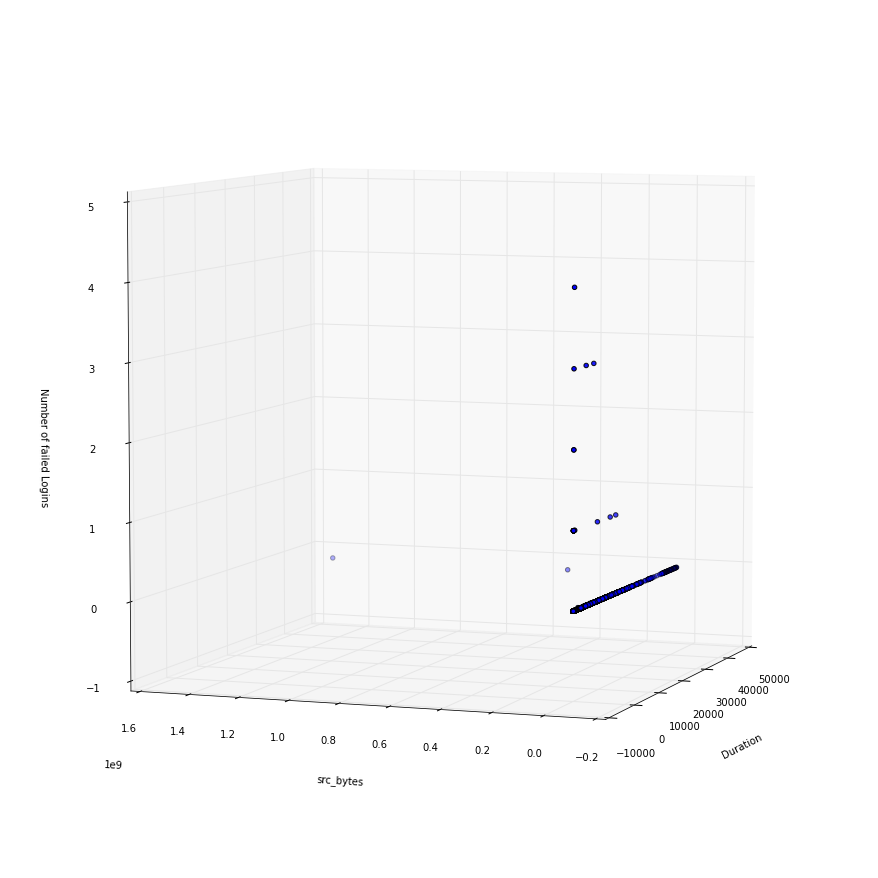

In [17]:
#plot the Datapoits
fig = plt.figure(figsize=(12, 12))
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=6, azim=200)
ax.scatter(dataSample[:, 0], dataSample[:, 1], dataSample[:, 7])

ax.set_xlabel('Duration')
ax.set_ylabel('src_bytes')
ax.set_zlabel('Number of failed Logins')

plt.show()

<div class="alert alert-warning">
<b>COMMENT:</b><br/>
Even though the network intrussion detection dataset has many features, we showed three candidates to have an inmpact in the network traffic characteristics. In general, the more that a feature is dispersed, the better it is to plot and help us visualize the clusters. Clearly the duration is a good candidate<br/><br/>
One way to plot the clusters with more accuracy is to use PCA to reduce the number of features that model the data. That's one of the options that could be discussed further down.<br/><br/>
Another process that we could apply to the data in order to achieve a better visualization is the feature normalization (substracting the mean and dividing by the standard deviation). This way we obtain a rather more homogeneous feature space. Also, some transformations for particular features could be useful in order to correct scale factors. For example, the source bytes seems to be a fueature with a lot of disparity.<br/><br/>
Finally, one final idea to consider: detecting and removing outliers based on the distance to their centroids once the clustering is done. After that, we could rerun the clustering, in hopes of achieving much better results.

</div>

### 2.2.2. Visualizing Features in Data

% of hot login:  0.0
% of guest login:  0.08497321567476124
% of conn.width < 0:  76.452946030779
% of root login:  0.007554082123897564


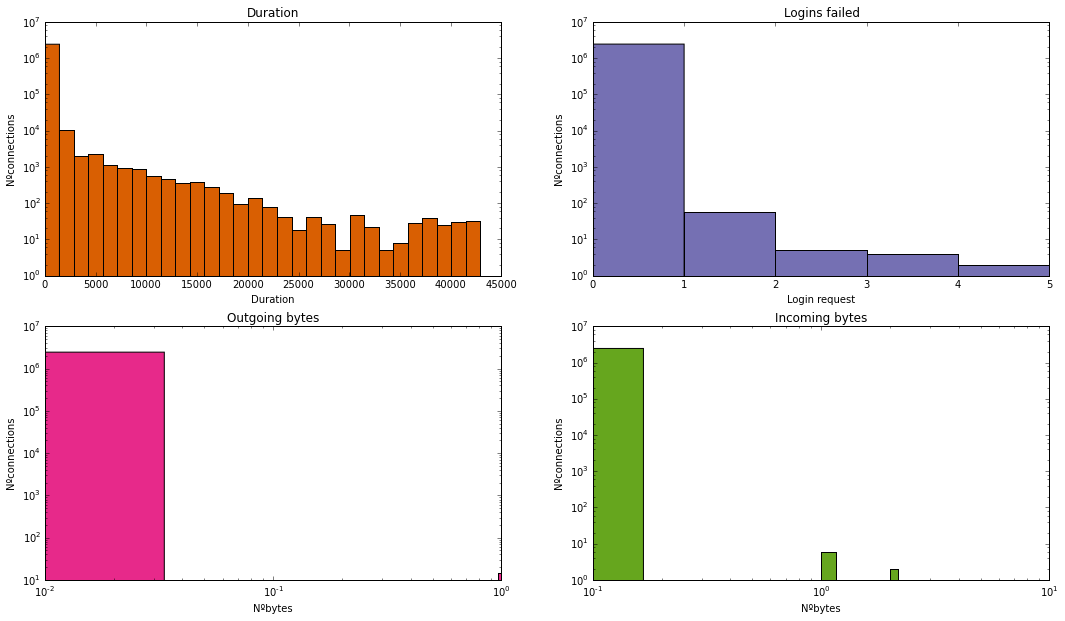

In [35]:
num = len(dataSample[:, 1])

plt.figure(figsize=(18,10))

# Feature 0 : Duration
plt.subplot(2, 2, 1)
plt.hist(dataSample[:, 0], 30, color=dark2_colors[1])
plt.yscale('log', nonposy='clip')
plt.title("Duration")
plt.xlabel("Duration")
plt.ylabel("Nºconnections")

# Feature 2 : Logins Failed
plt.subplot(2, 2, 2)
plt.hist(dataSample[:, 7], range(6), color=dark2_colors[2])
plt.yscale('log', nonposy='clip')
plt.title("Logins failed")
plt.xlabel("Login request")
plt.ylabel("Nºconnections")

#Feature 1 : Outgoing bytes
fig = plt.subplot(2, 2, 3)
plt.hist(dataSample[:, 3], 30, color=dark2_colors[3])
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposy='clip')
plt.title("Outgoing bytes")
plt.xlabel("Nºbytes")
plt.ylabel("Nºconnections")

# Feature 2: Incoming bytes
fig = plt.subplot(2, 2, 4)
plt.hist(dataSample[:, 5], 30, color=dark2_colors[4])
plt.yscale('log', nonposy='clip')
plt.xscale('log', nonposy='clip')
plt.title("Incoming bytes")
plt.xlabel("Nºbytes")
plt.ylabel("Nºconnections")

# Other 4 features
num_root = len(list(filter(lambda x: x==1, dataSample[:, 10])))
num_hot = len(list(filter(lambda x: x==1, dataSample[:, 17])))
num_guest = len(list(filter(lambda x: x==1, dataSample[:, 18])))
num_out_data = len(list(filter(lambda x: x>0, dataSample[:, 1])))
print("% of hot login: ", num_hot/num*100)
print("% of guest login: ", num_guest/num*100)
print("% of conn.width < 0: ", num_out_data/num*100)
print("% of root login: ", num_root/num*100)

plt.show()

<div class="alert alert-warning">
<b>COMMENT:</b><br/>
We analyzed some of the most important features in the data, doing some basic descriptive analytics and visualization. <br/><br/>

It seems like the number of bytes won't be a clarifying feature (neither incoming nor outoging), while the duration and the number of logins seem to hold some relative importance due to their diversity.<br/><br/>

Of course we could build an anomaly detection based on the individual performances on each of the features, where we labeled as anomaly anything out of the ordinary in our data inspection. But this approach would lack depth, and by clustering we will consider all the features combined.
    </div>

### 2.2.3. Evaluating model

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center.

</div>


In [24]:
from operator import add

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return np.power(e_dist(closest_center, point), 2)

WSSSE = data.map(lambda x: error(clusters_kpp, x)).reduce(add)
print("Within Set Sum of Squared Error = " + str(WSSSE))


Within Set Sum of Squared Error = 4.66345856702e+18


<div class="alert alert-warning">
<b>COMMENT:</b><br/>
    This WSSSE does not really tell us anything since the data is not normalized. When you normalize the data and then calculate the WSSSE it can be used as a measure. For the non-normalized case the WSSSE would relate to the number of datapoints in the dataset, as well as the scale of the features, thus not really giving away any information.
    </div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)


#### Question 5

<div class="alert alert-info">

This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Complete the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs.  

What do you think about the result?

</div>

In [25]:
clusterLabelCount = data.map(lambda p: (clusters_kpp.predict(p), 1)).reduceByKey(lambda a, b: a + b).collect()

print('KMeans 2 clusters:')
for item in clusterLabelCount:
    print(item)

# Extracted from typical wordcount:
clusterLabelCount2 = labelsAndData.map(lambda x: (x[0], 1)).reduceByKey(lambda x,y: x+y).collect()

print('Original clusters:')
for item in clusterLabelCount2:
    print(item)

KMeans 2 clusters:
(0, 4898430)
(1, 1)
Original clusters:
('guess_passwd.', 53)
('loadmodule.', 9)
('spy.', 2)
('phf.', 4)
('back.', 2203)
('pod.', 264)
('nmap.', 2316)
('smurf.', 2807886)
('satan.', 15892)
('land.', 21)
('warezmaster.', 20)
('ipsweep.', 12481)
('teardrop.', 979)
('multihop.', 7)
('neptune.', 1072017)
('buffer_overflow.', 30)
('perl.', 3)
('rootkit.', 10)
('imap.', 12)
('warezclient.', 1020)
('ftp_write.', 8)
('normal.', 972781)
('portsweep.', 10413)


<div class="alert alert-warning">
<b>COMMENT:</b><br/>
One single point in the second class and the rest in the other class. Clearly the second class is an outlier, which indicates that we need a higher K in order to correctly separate into classes.<br/><br/>
Nevertheless, the original classes already show a significant skewness: there are several classes with less tha 100 elements, while others have as much as millions.
</div>

### 2.2.4. Choosing K

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6
<div class="alert alert-info">
Complete the function below to calculate the MSE of each model that is corresponding to each value of $k$.  


Plot the results. From the obtained result, what is the best value for $k$? Why?

</div>

In [26]:
# k: the number of clusters
def clusteringScore(data, k):
    # OAH CHANGED INIT MODE!
    clusters = KMeans.train(data, k, maxIterations=10, initializationMode='kmeans||')
    # calculate mean square error
    return data.map(lambda x: error(clusters, x)).reduce(add)

In [35]:
scores = []
k_test = [5, 10, 15, 20]
for k in k_test:
    score = clusteringScore(data, k)
    scores.append(score)
    print("k=", k, " the score is:", score)

k= 5  the score is: 1.38625737923e+17
k= 10  the score is: 7.50135263482e+15
k= 15  the score is: 4.64916090407e+14
k= 20  the score is: 2.75843768551e+14


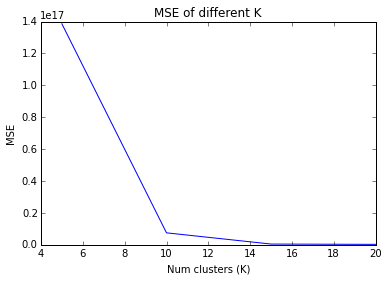

In [36]:
#k= 5  the score is: 1.38625737923e+17
#k= 10  the score is: 7.50135263482e+15
#k= 15  the score is: 4.64916090407e+14
#k= 20  the score is: 2.75843768551e+14

plt.plot(k_test, scores)
plt.title("MSE of different K")
plt.xlabel("Num clusters (K)")
plt.ylabel("MSE")
plt.show()

<div class="alert alert-warning">

<b>COMMENT:</b><br />

As expected the error decreases as the number of cluster increases, but this stops after a certain threshold, achieving convergence for arround 15 clusters. The MSE with random initialization was much less smooth in the convergence, due to the high dependency with a good initialization of the centroids, (up to the point of diverging when increasing K), but with initialization based on kmeans|| this problem is solved. 
</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Complete the code below to normalize the data. Print the first 5 lines of the new data.

</div>

<div class="label label-success">HINT</div> If $\sigma_i = 0$ then $normalize_i=feature_i - \mu_i$

In [27]:

def normalizeData(data):
    # number of connections
    n = data.count()

    # calculate means
    means = data.mean()

    # calculate standard deviation of each feature
    stdevs = data.stdev()

    def normalize(point):
        res = []
        
        for i in range(len(point)):
            if stdevs[i] == 0:
                res.append(point[i] - means[i])
            else:
                res.append((point[i] - means[i])/stdevs[i])
        return res

    return data.map(normalize)




In [28]:
normalizedData = normalizeData(data).cache()

In [29]:
normalizedData.take(5)

[[-0.06683318542420881,
  -0.001720382282287892,
  0.068188435127319452,
  -0.002390846860871979,
  -0.015139173434022768,
  -0.0011034846181947316,
  -0.02652075995496225,
  -0.0043909155847363995,
  2.4427918743642953,
  -0.0020973278346870065,
  -0.0082577083974692041,
  -0.004546461386643566,
  -0.0032845891671851204,
  -0.0095723392157848041,
  -0.0085045784245865279,
  -0.028756112730865285,
  0.0,
  -0.00063897900545820054,
  -0.028911303443117074,
  -1.5754150744340452,
  -1.196243238093317,
  -0.46604261387255441,
  -0.46575557391312739,
  -0.24828577490849504,
  -0.24813035170523645,
  0.53973309269996084,
  -0.2560565202907733,
  -0.20105929643802661,
  -3.6391392588276594,
  -1.7865104366036269,
  -1.8330227339690821,
  -0.28293900018696772,
  -1.2579366383587069,
  -0.1566684879542736,
  -0.46640478356659043,
  -0.46545364052902638,
  -0.25083182898698642,
  -0.2496319657767273],
 [-0.06683318542420881,
  -0.0017766795586854696,
  0.0053245145203947488,
  -0.00239084686087

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">

Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

</div>

In [30]:
scores2 = []
k_test2 = [5, 10, 15, 20, 25, 30, 40]
for k in k_test2:
    score = clusteringScore(normalizedData, k)
    scores2.append(score)
    print("k=", k, " the score is:", score)


k= 5  the score is: 125911646.768
k= 10  the score is: 74414059.7768
k= 15  the score is: 60187505.2633
k= 20  the score is: 39447912.2659
k= 25  the score is: 33245966.8094
k= 30  the score is: 16176021.5147
k= 40  the score is: 9969618.35305


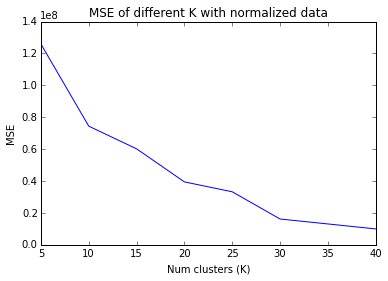

In [31]:
#SAVE SO THAT WE DONT HAVE TO RUN IT AGAIN! Scores for the original one
#scoresRandom = [6492820.25414, 4864526.31751, 3944194.81984, 3790404.60904, 2949423.86402, 2758981.59679]

plt.plot(k_test2, scores2)
plt.title("MSE of different K with normalized data")
plt.xlabel("Num clusters (K)")
plt.ylabel("MSE")
plt.show()

<div class='alert alert-warning'>
<b>COMMENT:</b><br/>
We decided to use kmeans|| as initialization mode instead of random, since this drastically reduces the number of clusters needed to converge. This is why we opted for lower numbers in our trials for K. However, we didn't find a minimum in the MSE after the normalization, which indicates that we could need a higher number for K in order to achieve convergence.<br/><br/>
After expanding the initial vector of Ks to 25-40, we start observing a slow convergence.

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9
<div class="alert alert-info">

Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

</div>

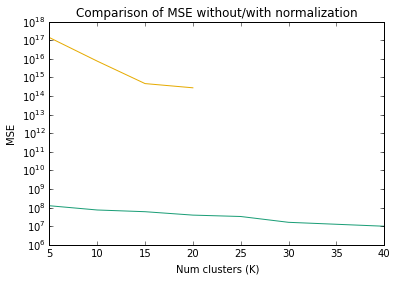

In [43]:
plt.plot(k_test, scores, color=dark2_colors[5])
plt.plot(k_test2, scores2, color=dark2_colors[7])
plt.title("Comparison of MSE without/with normalization")
plt.xlabel("Num clusters (K)")
plt.ylabel("MSE")

plt.yscale('log', nonposy='clip')
plt.show()

<div class="alert alert-warning">
<b>COMMENT:</b><br/>
As we can clearly see, the normalization of the features played a major role in substantially decreasing the MSE by uniformly rescaling the feature space. From our results we can clearly state that feature normalization is a MUST

</div>

<div class="alert alert-warning">
<b>COMMENT FOR THE WHOLE SECTION:</b><br/>
As result of this section, we set K =30 in order to achieve a good result as well as fast computation, always considering the normalized features

</div>

## 2.3. Clustering using categorical features

### 2.3.1 Loading data

In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, subtraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical feature into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorical feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping **one** categorical feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

In [40]:
# Different values of each feature
def get_categorical_features(line):
    cols = line.split(',')
    return cols[1:4]
dictFeatures = raw_data.flatMap(get_categorical_features).distinct().collect()
bdictFeatures = sc.broadcast(dictFeatures)
print(bdictFeatures.value)

['whois', 'pop_3', 'harvest', 'SH', 'uucp_path', 'other', 'systat', 'ecr_i', 'vmnet', 'remote_job', 'http', 'S1', 'kshell', 'OTH', 'time', 'name', 'Z39_50', 'tftp_u', 'udp', 'netbios_dgm', 'ftp', 'ldap', 'discard', 'domain_u', 'REJ', 'S2', 'eco_i', 'finger', 'http_2784', 'private', 'printer', 'sql_net', 'tcp', 'sunrpc', 'nnsp', 'daytime', 'exec', 'RSTOS0', 'pop_2', 'iso_tsap', 'urp_i', 'IRC', 'urh_i', 'http_443', 'RSTO', 'netbios_ns', 'ftp_data', 'domain', 'ctf', 'bgp', 'hostnames', 'mtp', 'netstat', 'login', 'klogin', 'ssh', 'nntp', 'S0', 'imap4', 'aol', 'tim_i', 'efs', 'RSTR', 'shell', 'csnet_ns', 'rje', 'smtp', 'S3', 'X11', 'telnet', 'http_8001', 'supdup', 'red_i', 'icmp', 'pm_dump', 'SF', 'echo', 'courier', 'ntp_u', 'netbios_ssn', 'uucp', 'gopher', 'auth', 'link']


In [37]:
###@!SOLUTION@!####

# c: index of the column
def getValuesOfColumn(data, c):
    return data.map(lambda x: x[c]).distinct().collect()

vColumn1 = getValuesOfColumn(raw_data, 1)
numValuesColumn1 = len(vColumn1)
vColumn1 = dict(zip(vColumn1, range(0, numValuesColumn1)))


vColumn2 = getValuesOfColumn(raw_data, 2)
numValuesColumn2 = len(vColumn2)
vColumn2 = dict(zip(vColumn2, range(0, numValuesColumn2)))



vColumn3 = getValuesOfColumn(raw_data, 3)
numValuesColumn3 = len(vColumn3)
vColumn3 = dict(zip(vColumn3, range(0, numValuesColumn3)))




def parseLineWithHotEncoding(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    featureOfCol1 = [0]*numValuesColumn1
    featureOfCol2 = [0]*numValuesColumn2
    featureOfCol3 = [0]*numValuesColumn3
    featureOfCol1[vColumn1[vector[1]]] = 1
    featureOfCol2[vColumn2[vector[2]]] = 1
    featureOfCol3[vColumn3[vector[3]]] = 1
    
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(list(map(lambda x: float(x), vector)))
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine)

# we only need the data, not the label
data = labelsAndData.values().cache()

In [38]:
###@!SOLUTION@!####
normalizedData = normalizeData(data).cache()

### 2.3.2. Building models

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11
<div class="alert alert-info">

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

</div>

In [41]:
scores3 = []
k_test3 = [15,20,25,30,40,50]
for k in k_test3:
    score = clusteringScore(normalizedData, k)
    scores3.append(score)
    print("k=", k, " the score is:", score)

k= 15  the score is: 59929916.0368
k= 20  the score is: 35587617.5653
k= 25  the score is: 31136226.8914
k= 30  the score is: 20041815.5639
k= 40  the score is: 10364820.9473
k= 50  the score is: 7631278.54551


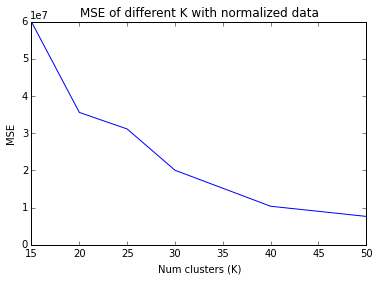

In [42]:
#scores3 = [4863656.16232, 3986095.78387, 3155417.67335, 2859843.32113,
 #          2671753.61993, 2367805.96305, 2242713.04678, 1946147.7417, 1841553.71711]
plt.plot(k_test3, scores3)
plt.title("MSE of different K with normalized data")
plt.xlabel("Num clusters (K)")
plt.ylabel("MSE")
plt.show()

<div class="alert alert-warning">
<b>COMMENT:</b><br/>
Just like before, since we use a more efficient initialization mode (kmeans|| instead of random), we don't get that many empty clusters, and thus we don't need such high values for K. We scaled down the values of K in a factor of 3.<br/><br/>

Comparing our results with the previous ones without categorical features, we have decreased the error twofold.<br/><br/>
From our results, we are selecting the value of <b>K=40</b>, to be used in the next computations. 



</div>

## 2.4. Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide when there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

</div>

<div class="label label-success">HINT</div> The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

In [44]:
k = 40
clusters = KMeans.train(data, k, maxIterations=10, initializationMode='kmeans||')

In [50]:
def plot_distance_dist(distances, binWidth):
    plt.figure(figsize=(13,7))
    # Take the maximum distance and divide by number of bins
    pltData = distances.map(lambda x: (int(x[0]/binWidth), x[1]))\
        .reduceByKey(lambda x, y: x+y).sortByKey()
    
    x = pltData.map(lambda x: int(x[0]*binWidth)).collect()
    y = pltData.map(lambda y: y[1]).collect()
    
    plt.xscale('log', nonposy='clip')
    plt.yscale('log', nonposy='clip')
    
    plt.title("Distribution of distances from points to clusters")
    plt.xlabel("Distance (log)")
    plt.ylabel("Number of points with x as distance (log)")
    
    plt.bar(x, y, color=dark2_colors[10])
    plt.show()
    
    return pltData

In [46]:
# Data distribution among their respective centroids
clusterDistribution = data.map(lambda x: (clusters.predict(x), 1)).reduceByKey(lambda y, z: y+z).sortByKey().collect()
    
centroids = clusters.centers
# Calculate the eucledian distances. Find the largest distances and their frequency
distances = data.map(lambda x: (e_dist(centroids[clusters.predict(x)], x), 1))\
    .reduceByKey(lambda y,z: y+z).sortByKey(ascending=False)
    
print("Largest Distances:", distances.take(5))

Distances: [(6197447.9304296533, 1), (1899910.8952228553, 1), (1796096.1478364388, 1), (1535613.268422982, 1), (1336118.5311628059, 1)]


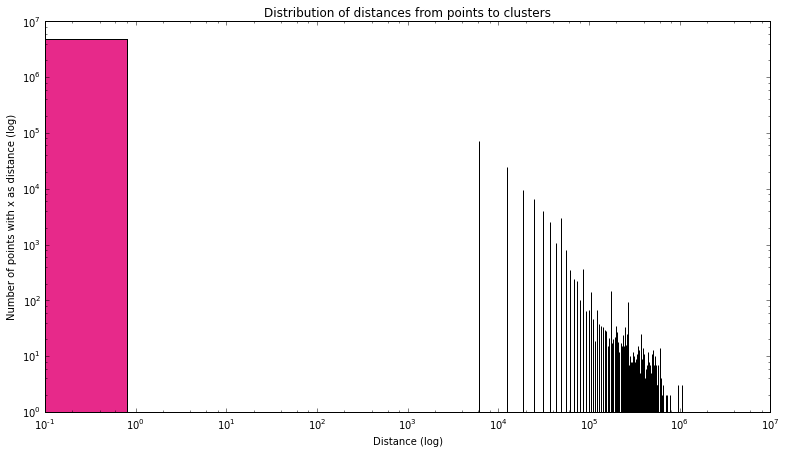

In [51]:
# Plot the distribution
numBins = 1000
binWidth = distances.take(1)[0][0]/numBins
pltData = plot_distance_dist(distances, binWidth).collect()

<div class="alert alert-warning">
<b>COMMENT:</b><br/>

The distance from the datapoints to the cluster centroids shows the majority of points being very close to the centroids, with a considerabli lower number at larger distances. Here we could already consider outliers to those surpassing a certain threshold<br/><br/>
In fact, An easy way to set the threshold based on that plot is to limit it to <b>threshold=100</b>, separating the large mass of points close to the centroids from those resting far away. INstead, we're gonna use the 100th farthest data point as suggested in the text above

</div>

In [53]:
#Calculate threshold
calc = 0
i = len(pltData)-1

while(calc < 100 and i > 0):
    calc += pltData[i][1]
    i -= 1
    
bThreshold = pltData[i][0]
print("Threshold for bins:", bThreshold)
    
threshold = binWidth * bThreshold
print("Threshold (distance to the 100th farthest point):", threshold)

Threshold for bins: 86
Threshold (distance to the 100th farthest point): 532980.522017


In [62]:
# Helper method for finding features
def calc_feature_diff(p):
    closestCentroid = clusters.centers[clusters.predict(p)]
    return [(i, np.abs(closestCentroid[i] - p[i])) for i in range(len(p))]
    
# Get the poins furthest away
pointsFurhtestAway = data.filter(lambda x: e_dist(centroids[clusters.predict(x)], x) > threshold)

featuresFurthestAway = pointsFurhtestAway.flatMap(calc_feature_diff).reduceByKey(lambda y,z: y+z)\
    .sortBy(lambda x: x[1], ascending=False)

In [57]:
feature_names = ['duration'] + dictFeatures + ['src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
        'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
        'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
        'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
        'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
        'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate']
bFeature_names = sc.broadcast(feature_names)

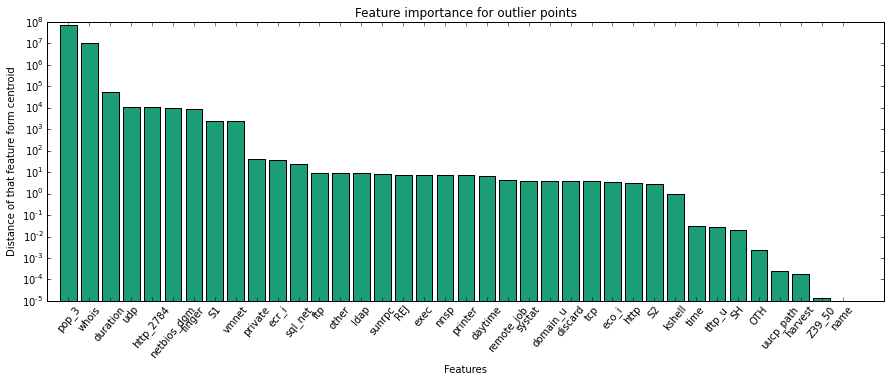

In [64]:

#print(featuresFurthestAway.take(2))

x = featuresFurthestAway.map(lambda x: bFeature_names.value[x[0]]).collect()
y = featuresFurthestAway.map(lambda y: y[1]).collect()



plt.figure(figsize=(15,5))
plt.title("Feature importance for outlier points")
plt.xlabel("Features")
plt.yscale('log', nonposy='clip')
plt.ylabel("Distance of that feature from centroid")
plt.bar(range(1,len(y)+1), y, align="center", color=dark2_colors[0])
plt.xticks(range(1,len(y)+1), x, rotation=50)
plt.show()

<div class="alert alert-warning">
<b>COMMENT:</b><br/>

From the plot above we can extract the most useful features in order to generate the clusters, :<br/>
<ul>
<li><b>pop_3</b>: Related to protocols for email, bidirectional.</li>
<li><b>whois</b>: Digital identity (probably IP direction and port) of the other end of the connection. Clearly important!</li>
<li><b>duration</b>: We already showed this in question 3, since it has a wide range of evenly distributed values, it allows good clustering.</li>
</ul>
Also we can check the least useful, name, which unsurprisingly has no impact in the clustering.

</div>

#### Question 13
<div class="alert alert-info">

Try other methods to find the best value for $k$ such as `silhouette`, `entropy`... In particular, with this data, you can take advantage of predefined labels to calculate the quality of model using entropy... However, we suggest you to try with `silhouette`. It's more general and can work with any dataset (with and without predefined labels).

</div>

Here are some additional information about the metrics we suggest to use:
- [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [Hack approach to Silhouette](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Entropy](http://scikit-learn.org/stable/modules/clustering.html) [Lookup for entropy]

<div class="label label-danger">Note</div> you are free to play with any relevant evaluation metric you think appropriate for your work!

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.440266126301


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


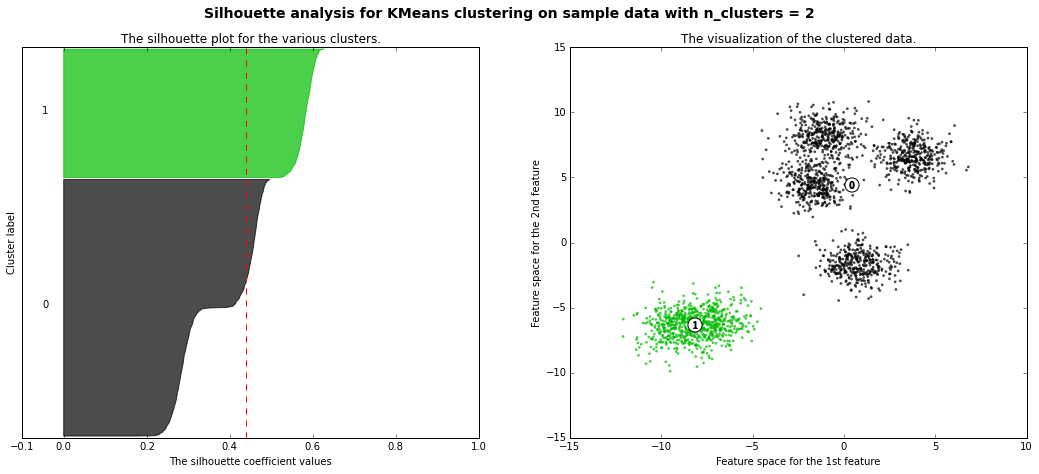

For n_clusters = 3 The average silhouette_score is : 0.570176937775


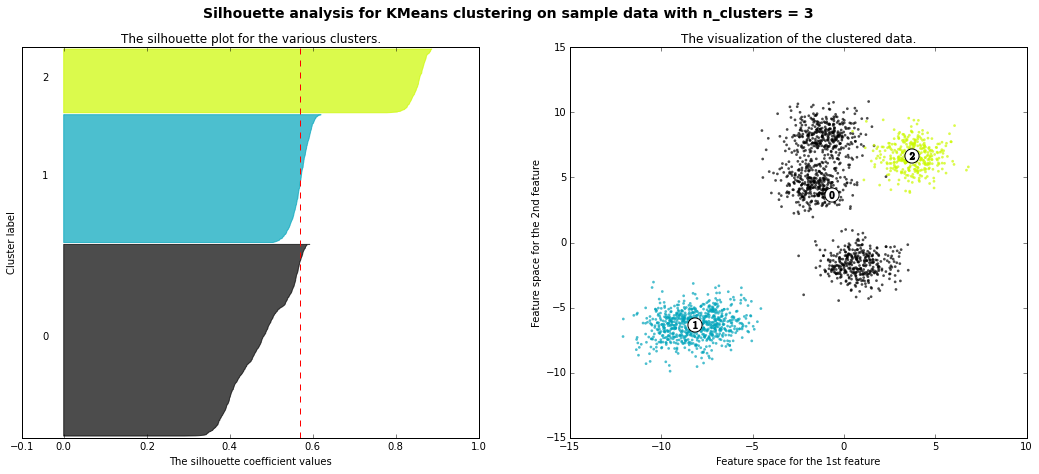

For n_clusters = 4 The average silhouette_score is : 0.660525295445


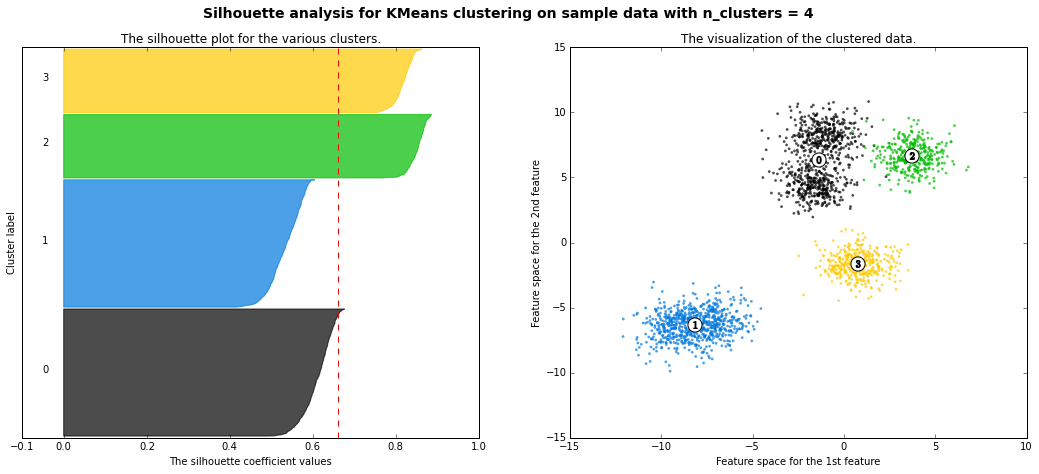

For n_clusters = 5 The average silhouette_score is : 0.750412490301


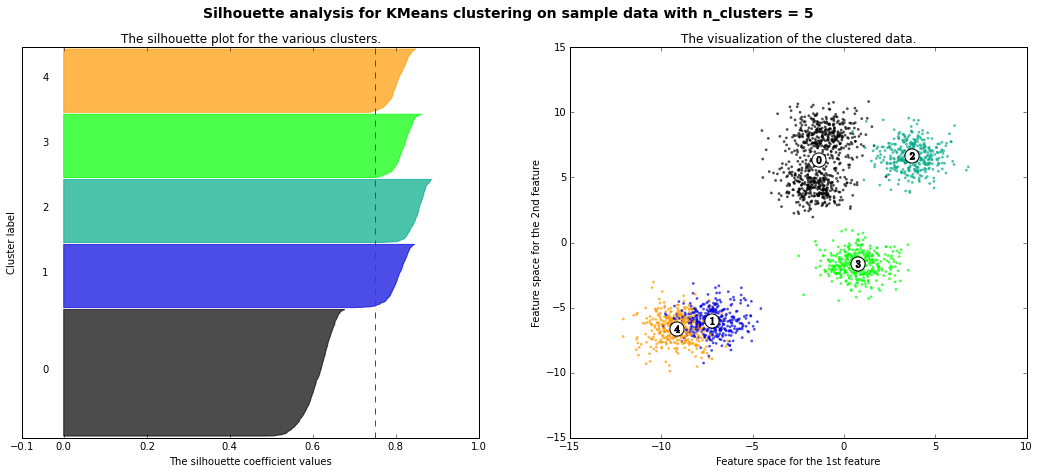

For n_clusters = 6 The average silhouette_score is : 0.773203195489


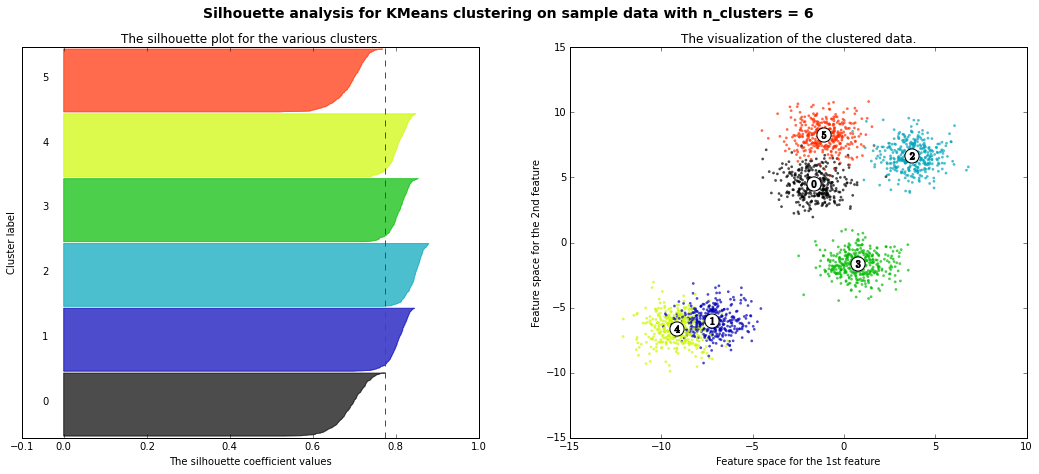

In [10]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=2200,
                  n_features=9,
                  centers=6,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

<div class="alert alert-warning">
<b>COMMENT:</b><br/>
The silhouette is a very computationally intensive algorithm, with O(n^2), meaning that it scales awfully for Big Data (in our case 5Million points). Nevertheless, after playing a bit with the demo we could implement it to a random subset of the data keeping in mind the risk of not covering representative outliers. The silhouette would then allow us to much more carefully chose K.
</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Implement K-means on Spark so that It can work with large datasets in parallel. Test your algorithm with our dataset in this notebook. Compare our algorithm with the algorithm from MLLIB.  

<ul></ul>

Let's clarify the meaning of this question: what we want is for students to design the K-means algorithm for the parallel programming model exposed by Spark. You are strongly invited to use the Python API (pyspark). So, at the end of the day, you will operate on RDDs, and implement a `map/reduce` algorithm that performs the two phases of the standard K-means algorithm, i.e. the assignment step and the update step.

</div>